## Introduction to the Quantum Monte Carlo Wave Function Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### A two-level system

We consider a simple two-level system driven at a Rabi frequency $\Omega$, detuned by $\Delta$, and undergoing spontaneous decay at a rate $\Gamma$. Setting $\hbar = 1$, the quantum Monte-Carlo Hamiltonian is (also see [Mølmer _et al._](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-10-3-524)):
$$
    \mathcal{H} = \frac{\Omega}{2} \left( |e\rangle\langle g| + |g\rangle\langle e| \right) - \Delta |e\rangle\langle e| - \frac{i\Gamma}{2} \Delta |e\rangle\langle e|
$$

If the wavefunction is given by $|\psi\rangle = \alpha |g\rangle + \beta|e\rangle$, we can evolve this using the Euler method over a timestep $dt$ using the following prescription:

\begin{align}
    \alpha &\mapsto \alpha - i\,dt \frac{\Omega \beta}{2} \\ 
    \beta &\mapsto \beta - i\,dt\left( \frac{\Omega\alpha}{2} - \Delta\beta - \frac{i\Gamma\beta}{2} \right)
\end{align}

We define this as follows:

In [77]:
def step(alpha, beta):
    alphaN = alpha - 1j * dt * Omega * beta / 2
    betaN = beta - 1j * dt * ( Omega * alpha / 2 - Delta*beta - 1j*Gamma*beta/2)

    return alphaN, betaN

#### The trivial case
Let's see what happens when we set $\Delta = \Gamma = 0$, we expect an undamped Rabi oscillation. (Without any decoherence we are here just applying the Euler method to the evolution fo a two-level system. Technically this is not recommended because it is not norm-preserving. This can be 'solved' by choosing a small time step.)

In [121]:
Delta = 0
Gamma = 0
Omega = 1 * 2*np.pi

Define a time axis:

In [122]:
dt = 1/100000
timeax = np.arange(0,2,dt)

Do the evolution:

In [123]:
alphaO = 1.0
betaO = 0.0

alpha = np.zeros(len(timeax), dtype=complex)
beta = np.zeros(len(timeax), dtype=complex)

alpha[0] = alphaO
beta[0] = betaO

for i in range(1, len(timeax)):
    (alphaO, betaO) = step(alphaO, betaO)

    alpha[i] = alphaO
    beta[i] = betaO

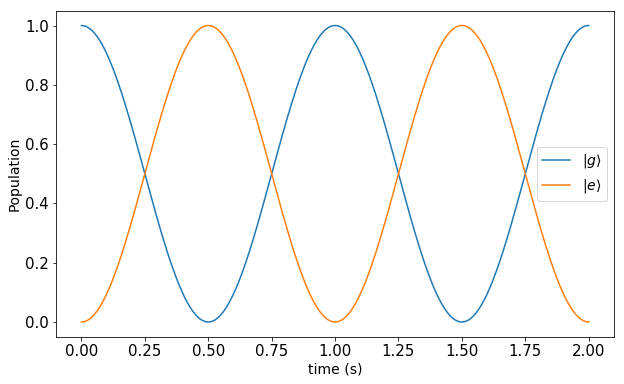

In [124]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(timeax, np.abs(alpha)**2)
ax.plot(timeax, np.abs(beta)**2)

plt.xlabel(r'time (s)', fontsize=14)
plt.ylabel(r'Population', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize = 15)
ax.legend([r'$|g\rangle$', r'$|e\rangle$'], fontsize = 14)

plt.show()

#### The decaying case
Now we set $\Gamma = \Omega/2$, we leave $\Delta = 0$. We look at the behavior by using the Quantum Monte Carlo formalism.

In [129]:
Delta = 0
Omega = 1 * 2*np.pi
Gamma = Omega / 2

In [130]:
dt = 1/1000
timeax = np.arange(0,2,dt)

The QMC recipe is as follows:
 1. Take a time step $dt$.
 2. Draw a random number, if it is smaller than $\beta^2\Gamma\, dt$ a photon has been emitted. In that case reset the atom to its ground state. Otherwise renormalize the population to make up for the non-Hermitian Hamiltonian. 
 3. Repeat until the final time has been reached.

In [142]:
def MCTrajectory(ntraj):
    # Make some space
    alphaPop = np.zeros(len(timeax), dtype=complex)
    betaPop = np.zeros(len(timeax), dtype=complex)
    
    for traj in range(ntraj):
        # Initial conditions
        alphaO = 1.0
        betaO = 0.0
        
        # Define first points
        alphaPop[0] = alphaO
        betaPop[0] = betaO

        # Draw all MC numbers now, saves time later
        rs = np.random.random(len(timeax))

        for i in range(1, len(timeax)):
            # Step 1. Update populations
            (alphaO, betaO) = step(alphaO, betaO)

            # Step 2. Do we make a jump?
            dp = Gamma*dt*np.abs(betaO)**2
            r = rs[i]
            if r <= dp:
                # We make a jump: population back to |g> and give a random kick
                alphaO = 1.0
                betaO = 0.0
            else:
                # We don't make a jump; renormalize the wave function
                alphaO = alphaO / np.sqrt(1 - dp)
                betaO = betaO / np.sqrt(1 - dp)

            # Store populations
            alphaPop[i] += np.abs(alphaO)**2 / ntraj
            betaPop[i] += np.abs(betaO)**2 / ntraj
    return alphaPop, betaPop

Draw some trajectories:

In [153]:
numtrajs = np.array([1, 10, 100, 1000])
alphaPops = []
betaPops = []
for numtraj in numtrajs:
    (alphaDum, betaDum) = MCTrajectory(numtraj)
    alphaPops.append( alphaDum )
    betaPops.append( betaDum )

Plot them together:

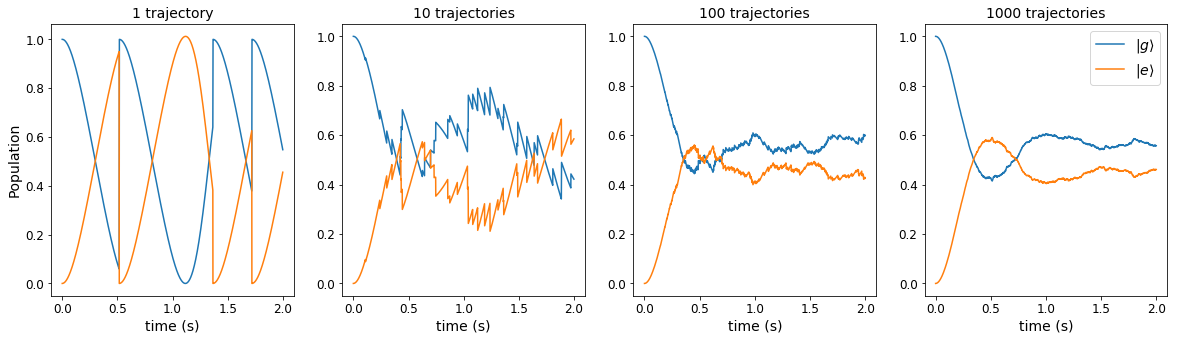

In [175]:
fig, ax = plt.subplots(1, 4, figsize = (20,5))

for i in range(4):
    ax[i].plot(timeax, alphaPops[i])
    ax[i].plot(timeax, betaPops[i])
    ax[i].set_xlabel(r'time (s)', fontsize = 14)
    ax[i].tick_params(axis='both', which='major', labelsize = 12)
    ax[i].set_title('%d trajectories' % numtrajs[i], fontsize = 14)

ax[0].set_title('1 trajectory', fontsize = 14)
ax[0].set_ylabel(r'Population', fontsize = 14)
ax[3].legend([r'$|g\rangle$', r'$|e\rangle$'], fontsize = 14)

plt.show()